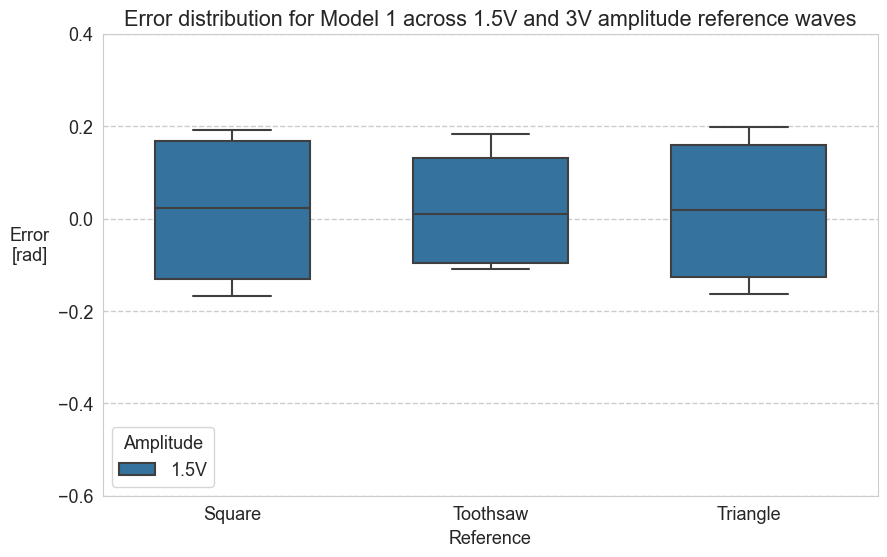

In [132]:
from src.data_processing import process_file
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib as mpl
from sklearn.metrics import r2_score
import numpy as np

# Metrics functions as defined earlier
def nrmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    nrmse_value = rmse / np.std(y_true)
    return nrmse_value

def fit_percentage(y_true, y_pred):
    numerator = np.sum((y_true - y_pred)**2)
    denominator = np.sum((y_true - np.mean(y_true))**2)
    fit_perc = (1 - numerator/denominator) * 100
    return fit_perc

# Set the font size globally
mpl.rcParams.update({'font.size': 13})  # Change 14 to your desired font size

# Function to process experiments and return errors DataFrame with amplitude label
def get_errors(file_paths_exp, file_paths_sim, amplitude_label):
    errors_df_list = []
    r_squared_list = []
    nrmse_value_list = []
    fit_perc_list = []

    for i, fp in enumerate(file_paths_sim):
        sim_data = pd.read_csv(fp)
        real_data = pd.read_csv(file_paths_exp[i])
        interpolator = interp1d(sim_data['time'], sim_data['pos_sim'], kind='linear', fill_value="extrapolate")
        
        interpolated_positions = interpolator(real_data['t'])

        y_true = real_data['DXL_Position']
        y_pred = interpolated_positions
        # Calculate error for each experiment
        error = y_true - y_pred

        # Calculate Metrics
        r_squared_list.append(r2_score(y_true, y_pred))
        nrmse_value_list.append(nrmse(y_true, y_pred))
        fit_perc_list.append(fit_percentage(y_true, y_pred))
        
        # Now create a DataFrame for each reference type with a common structure
        ref_type = ['Square', 'Toothsaw', 'Triangle'][i]
        for e in error:
            errors_df_list.append({'Reference': ref_type, 'Error [rad]': e, 'Amplitude': amplitude_label})

    # Create a DataFrame from the list of dictionaries
    errors_df = pd.DataFrame(errors_df_list)
    
    return errors_df, r_squared_list, nrmse_value_list, fit_perc_list

# exp1 -> exp3 => 3V
# exp4 -> exp6 => 1.5V

# Select the measurements
file_paths_exp_1_5 = [
    "data/current_exp/real/exp1_square_12.csv",
    "data/current_exp/real/exp1_tooth_12.csv",
    "data/current_exp/real/exp1_triangle_12.csv"
]
file_paths_exp_1_5 = [
    "data/current_exp/real_pwm_ctrl/square.csv",
    "data/current_exp/real_pwm_ctrl/tooth.csv",
    "data/current_exp/real_pwm_ctrl/triangle.csv"
]
folder = "simu_current"
folder = "simu_current+friction"
folder = "pwm1+friction"
folder = "pwm_ctrl+friction"
file_paths_sim_1_5 = [
    f"data/current_exp/{folder}/square.csv",
    f"data/current_exp/{folder}/tooth.csv",
    f"data/current_exp/{folder}/triangle.csv"
]

# Get errors for 1.5V and 3V experiments
errors_1_5V_df, _, _, _ = get_errors(file_paths_exp_1_5, file_paths_sim_1_5, '1.5V')

# Combine the errors into one DataFrame
combined_errors_df = pd.concat([errors_1_5V_df])

def plot_distr_err(combined_errors_df, model_name = "Model 1"):
    # Plotting the combined errors
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=combined_errors_df, x='Reference', y='Error [rad]', hue='Amplitude', width=0.6, saturation=0.7, linewidth=1.5)
    plt.title(f'Error distribution for {model_name} across 1.5V and 3V amplitude reference waves')
    sns.set_style("whitegrid")
    plt.grid(axis='y', linestyle='--', linewidth=1)
    # plt.legend(title='Amplitude', bbox_to_anchor=(0.2, 1), loc='upper left')
    plt.legend(title='Amplitude', loc='lower left')
    plt.ylabel('Error\n[rad]', labelpad=20, rotation=0)
    plt.ylim(-0.6, 0.4)  # Setting the y-axis limits
    plt.show()

plot_distr_err(combined_errors_df)

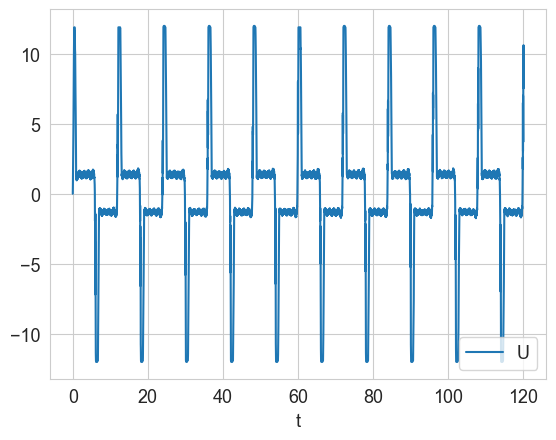

In [130]:
units = 100/(0.113 * 12)

my_df = file_paths_exp_1_5[0]
my_df = pd.read_csv(my_df)
my_df.plot(x='t', y='U')
signal = my_df['U'].values

# Create DataFrame
df_signal = pd.DataFrame({
    'time': my_df['t'].values,
    'q1_l': my_df['U'].values * units,
    'q1_r': my_df['U'].values * units,  
    'q2_l': my_df['U'].values * units,
    'q2_r': my_df['U'].values * units,
})

# df_signal.to_csv('data/current_exp/signal.csv', index=False)

In [133]:
import numpy as np
import pandas as pd

# Constants
time_step = 5e-3  # Time step in seconds
total_time = 120  # Total time for the experiment
time = np.arange(0, total_time, time_step)
fundamental_period = 12  # Fundamental period for both waves
omega = 2 * np.pi / fundamental_period  # Angular frequency of the fundamental frequency
amplitude = 0.14 # Amplitude of the waves

# Functions for generating waves (as you have defined)

def generate_fourier_square_wave(time, omega, amplitude, n_harmonics=5):
    wave = np.zeros_like(time)
    for n in range(1, n_harmonics * 2, 2):  # Only odd harmonics
        wave += (4 * amplitude / (n * np.pi)) * np.sin(n * omega * time)
    return wave

def generate_fourier_sawtooth_wave(time, omega, amplitude, n_harmonics=5):
    wave = np.zeros_like(time)
    for n in range(1, n_harmonics + 1):  # Both odd and even harmonics
        wave += (2 * amplitude / (n * np.pi)) * (-1) ** (n + 1) * np.sin(n * omega * time)
    return wave

def generate_fourier_triangle_wave(time, omega, amplitude, n_harmonics=5):
    wave = np.zeros_like(time)
    for n in range(1, n_harmonics * 2, 2):  # Only odd harmonics
        wave += ((8 * amplitude) / ((n * np.pi) ** 2)) * np.sin(n * omega * time)
    return wave

# Generate waves
square_wave = generate_fourier_square_wave(time, omega, amplitude)
sawtooth_wave = generate_fourier_sawtooth_wave(time, omega, amplitude)
triangle_wave = generate_fourier_triangle_wave(time, omega, amplitude * 1.5)

# Create DataFrames
df_square_wave = pd.DataFrame({'time': time, 'value': square_wave})
df_sawtooth_wave = pd.DataFrame({'time': time, 'value': sawtooth_wave})
df_triangle_wave = pd.DataFrame({'time': time, 'value': triangle_wave})

waves = [df_square_wave, df_sawtooth_wave, df_triangle_wave]

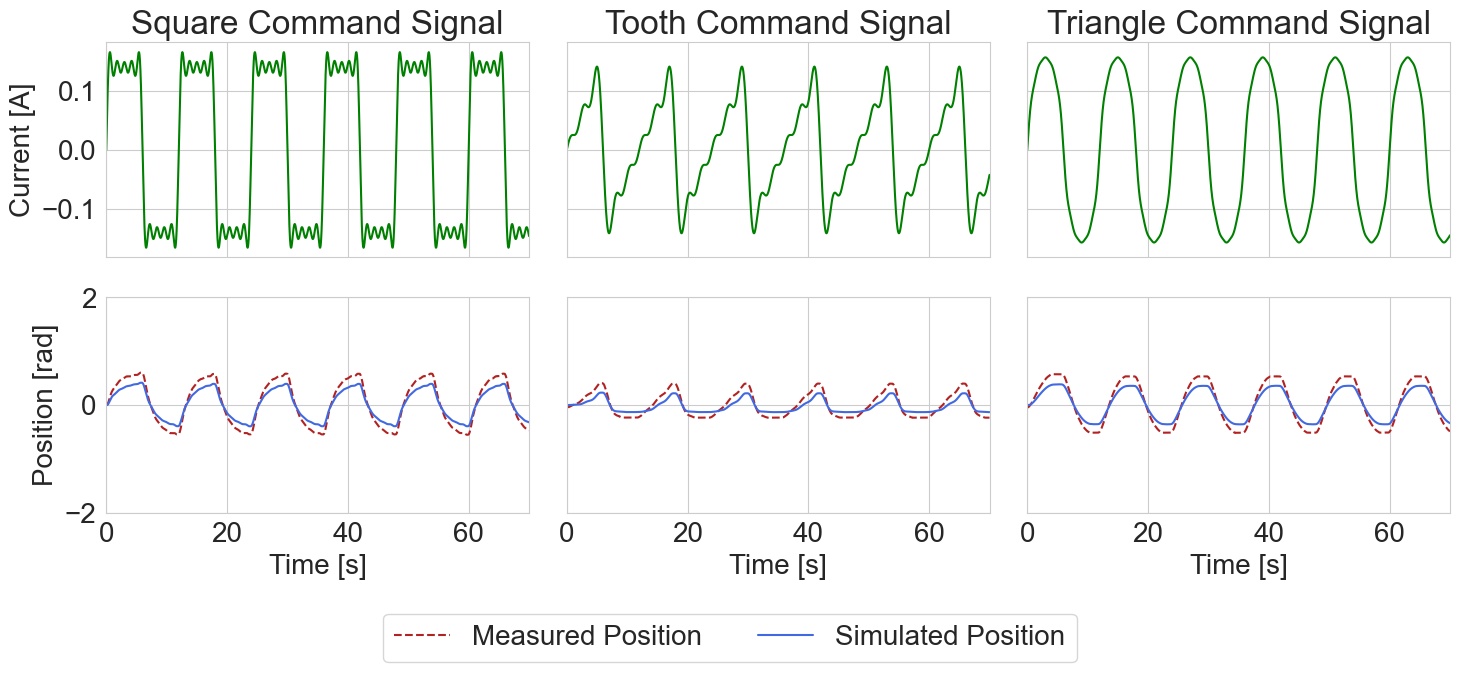

In [134]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

# Set the font size globally
mpl.rcParams.update({'font.size': 20})  # Change 14 to your desired font size

# Assuming file_paths_exp_3 and file_paths_exp_1_5 are defined
# And contain paths to your real experiment data for 3V and 1.5V experiments, respectively
experiment_labels = ["Square", "Tooth", "Triangle"]

# Create subplots with 2 columns (for 1.5V and 3V) and 3 rows (for each waveform type)
fig, axs = plt.subplots(2, 3, figsize=(15, 7), sharex='col', sharey='row')

# Time limit for plotting
time_limit = 70

# Plot signals
for i, label in enumerate(experiment_labels):
    data = pd.read_csv(file_paths_exp_1_5[i])
    data_filtered = data[data['t'] <= time_limit]
    
    # axs[0, i].plot(data_filtered['t'], data_filtered['DXL_Current'], color='green')
    axs[0, i].plot(waves[i].time, waves[i].value, color='green')
    axs[0, i].set_title(f'{label} Command Signal')
    axs[0, i].set_ylabel('Current [A]')
    axs[1, i].set_xlim(0, time_limit)
    axs[0, i].grid(True)

for i, label in enumerate(experiment_labels):
    data = pd.read_csv(file_paths_exp_1_5[i])
    data_filtered = data[data['t'] <= time_limit]

    sim_data_1_5V = pd.read_csv(file_paths_sim_1_5[i])

    interpolator_1_5V = interp1d(sim_data_1_5V['time'], sim_data_1_5V['pos_sim'], bounds_error=False, fill_value='extrapolate')
    sim_interp_positions_1_5V = interpolator_1_5V(data_filtered['t'])
    
    axs[1, i].plot(data_filtered['t'], data_filtered['DXL_Position'], label='Measured Position', linestyle = "--", color='firebrick')
    axs[1, i].plot(data_filtered['t'], sim_interp_positions_1_5V, label='Simulated Position', color='royalblue')

    # axs[1, i].set_title(f'{label} 1.5V Command Signal')
    axs[1, i].set_ylabel('Position [rad]')
    axs[1, i].grid(True)
    # axs[1, i].legend(bbox_to_anchor=(1, 0), loc='lower right')
    axs[1, i].set_ylim(-2, 2)
    axs[1, i].set_xlim(0, time_limit)

# for i, label in enumerate(experiment_labels):
#     data = pd.read_csv(file_paths_exp_1_5[i])
#     data_filtered = data[data['t'] <= time_limit]

#     sim_data_1_5V = pd.read_csv(file_paths_sim_1_5[i])

#     interpolator_1_5V = interp1d(sim_data_1_5V['time'], sim_data_1_5V['vel_sim'], bounds_error=False, fill_value='extrapolate')
#     sim_interp_positions_1_5V = interpolator_1_5V(data_filtered['t'])
    
#     axs[2, i].plot(data_filtered['t'], data_filtered['DXL_Velocity'], label='Measured Position', color='red')
#     axs[2, i].plot(data_filtered['t'], sim_interp_positions_1_5V, label='Simulated Position', color='blue')

#     # axs[1, i].set_title(f'{label} 1.5V Command Signal')
#     axs[2, i].set_ylabel('Position [rad]')
#     axs[2, i].grid(True)
#     axs[2, i].legend(bbox_to_anchor=(1, 0), loc='lower right')
#     axs[2, i].set_ylim(-2, 2)
#     axs[2, i].set_xlim(0, time_limit)


# Setting common labels
for ax in axs.flat:
    ax.set(xlabel='Time [s]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Create a single legend
lines, labels = axs[1, 0].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', ncol=2)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space at the bottom for the legend
plt.show()

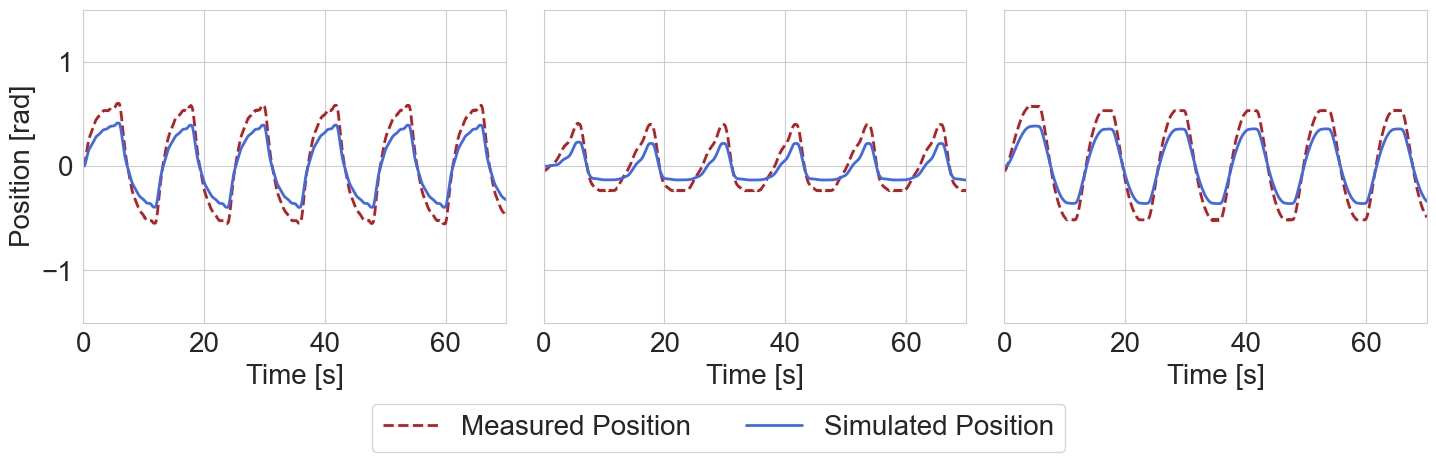

In [135]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

# Set the font size globally
mpl.rcParams.update({'font.size': 20})  # Change 14 to your desired font size

# Assuming file_paths_exp_3 and file_paths_exp_1_5 are defined
# And contain paths to your real experiment data for 3V and 1.5V experiments, respectively
experiment_labels = ["Square", "Tooth", "Triangle"]

# Create subplots with 2 columns (for 1.5V and 3V) and 3 rows (for each waveform type)
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex='col', sharey='row')

# Time limit for plotting
time_limit = 70

for i, label in enumerate(experiment_labels):
    data = pd.read_csv(file_paths_exp_1_5[i])
    data_filtered = data[data['t'] <= time_limit]

    sim_data_1_5V = pd.read_csv(file_paths_sim_1_5[i])

    interpolator_1_5V = interp1d(sim_data_1_5V['time'], sim_data_1_5V['pos_sim'], bounds_error=False, fill_value='extrapolate')
    sim_interp_positions_1_5V = interpolator_1_5V(data_filtered['t'])
    
    axs[i].plot(data_filtered['t'], data_filtered['DXL_Position'], label='Measured Position', linestyle = "--", color='firebrick', linewidth=2)
    axs[i].plot(data_filtered['t'], sim_interp_positions_1_5V, label='Simulated Position', color='royalblue', linewidth=2)
    axs[i].set_ylabel('Position [rad]')
    axs[i].grid(True)
    axs[i].set_ylim(-1.5, 1.5)
    axs[i].set_xlim(0, time_limit)

# Setting common labels
for ax in axs.flat:
    ax.set(xlabel='Time [s]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Create a single legend
lines, labels = axs[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', ncol=2)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space at the bottom for the legend
plt.show()

In [136]:
errors_1_5V_df, r_squared_list, nrmse_value_list, fit_perc_list = get_errors(file_paths_exp_1_5, file_paths_sim_1_5, '1.5V')

# Combine the metrics from both 3V and 1.5V experiments
total_r_squared_list = r_squared_list
total_nrmse_value_list = nrmse_value_list
total_fit_perc_list = fit_perc_list

# Calculate the average of each metric
avg_r_squared = sum(total_r_squared_list) / len(total_r_squared_list)
avg_nrmse = sum(total_nrmse_value_list) / len(total_nrmse_value_list)
avg_fit_percentage = sum(total_fit_perc_list) / len(total_fit_perc_list)

# Print the averages
print(f"Average R-squared for Model : {avg_r_squared:.4f}")
print(f"Average NRMSE for Model : {avg_nrmse:.4f}")
print(f"Average Fit Percentage for Model : {avg_fit_percentage:.2f}%")

Average R-squared for Model : 0.8470
Average NRMSE for Model : 0.3836
Average Fit Percentage for Model : 84.70%


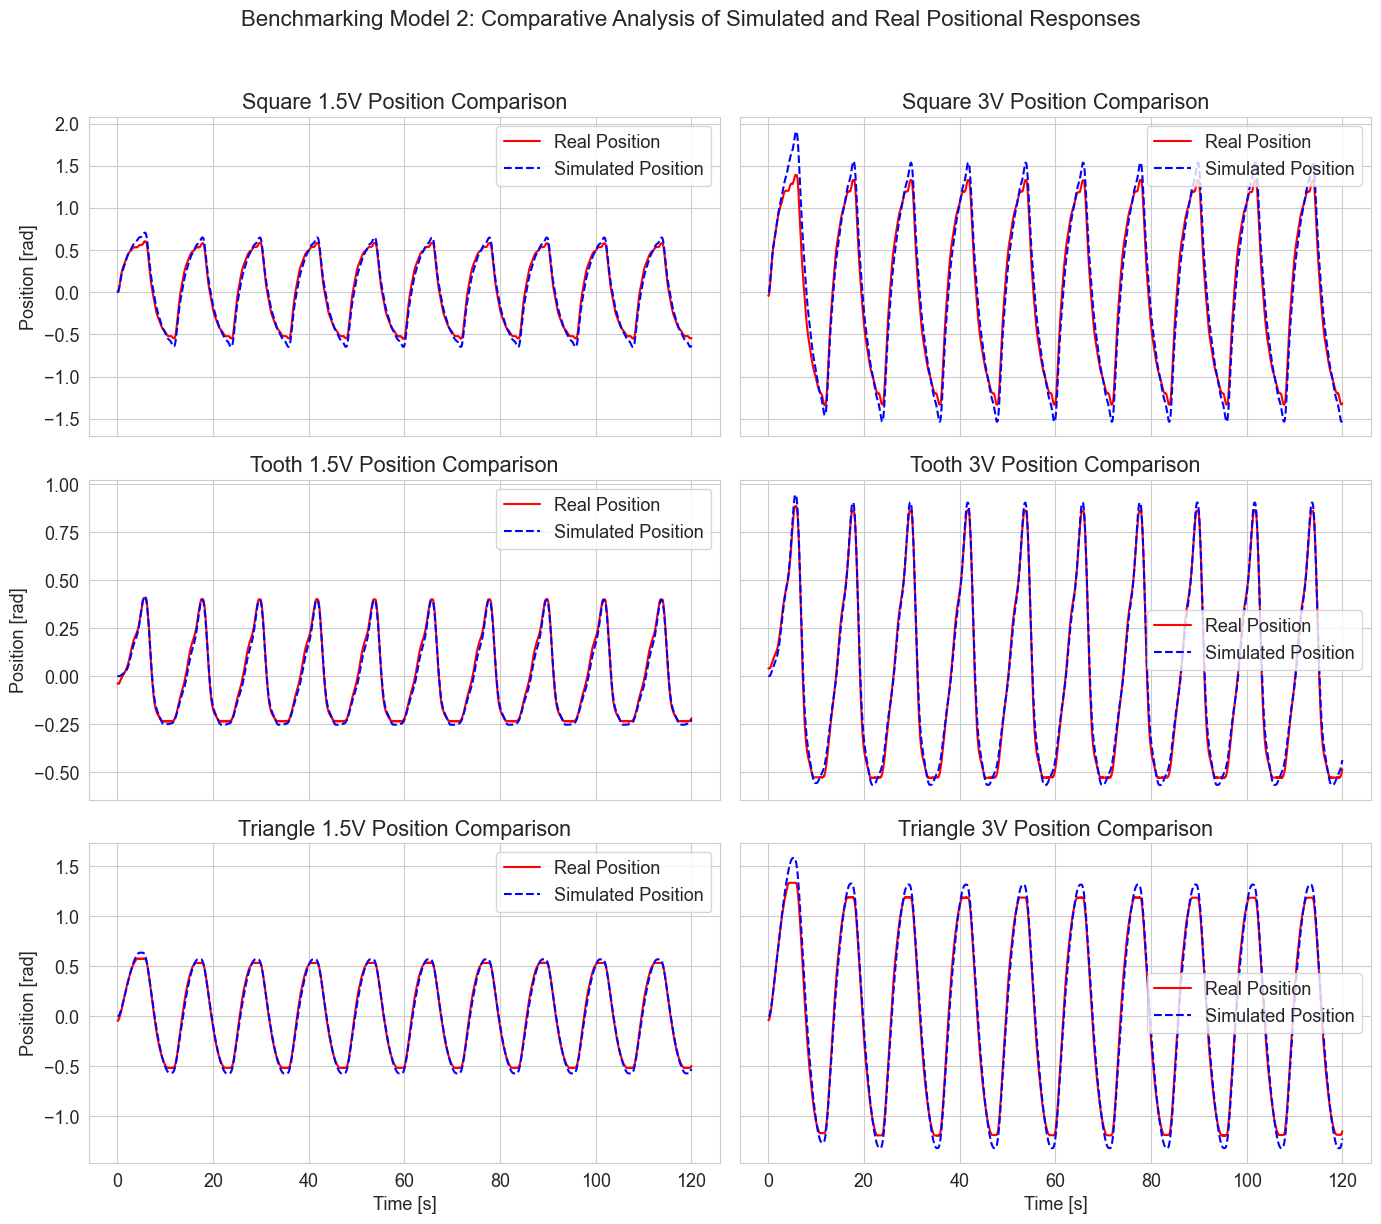

In [6]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd

# Time limit for plotting
time_limit = 120

# Experiment labels for organizing subplots
experiment_labels = ["Square", "Tooth", "Triangle"]

# Create subplots with 2 columns (for 1.5V and 3V) and 3 rows (for each waveform type)
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharex='col', sharey='row')

# Loop through each model number for plotting
# Assuming model_num is set to the model you want to plot. Set or loop as needed.
model_num = 3

# Plot position comparisons: 1.5V amplitude signals on the left, 3V on the right
for i, exp_label in enumerate(experiment_labels):
    # Processing 1.5V experiments
    real_data_path_1_5V = file_paths_exp_1_5[i]
    real_data_1_5V = process_file(real_data_path_1_5V, delta_t=0.02)
    real_data_1_5V['DXL_Position'] -= np.pi / 2
    real_data_1_5V_filtered = real_data_1_5V[real_data_1_5V['t'] <= time_limit]

    sim_file_path_1_5V = f"{base_folder}/simu_model{model_num}_exp{i+4}.csv"  # exp4, exp5, exp6 for 1.5V
    sim_data_1_5V = pd.read_csv(sim_file_path_1_5V)

    interpolator_1_5V = interp1d(sim_data_1_5V['Time'], sim_data_1_5V['Position'], bounds_error=False, fill_value='extrapolate')
    sim_interp_positions_1_5V = interpolator_1_5V(real_data_1_5V_filtered['t'])

    axs[i, 0].plot(real_data_1_5V_filtered['t'], real_data_1_5V_filtered['DXL_Position'], label='Real Position', color='red')
    axs[i, 0].plot(real_data_1_5V_filtered['t'], sim_interp_positions_1_5V, label='Simulated Position', linestyle='--', color='blue')
    axs[i, 0].set_title(f'{exp_label} 1.5V Position Comparison')
    axs[i, 0].grid(True)
    axs[i, 0].legend()

    # Processing 3V experiments
    real_data_path_3V = file_paths_exp_3[i]
    real_data_3V = process_file(real_data_path_3V, delta_t=0.02)
    real_data_3V['DXL_Position'] -= np.pi / 2
    real_data_3V_filtered = real_data_3V[real_data_3V['t'] <= time_limit]

    sim_file_path_3V = f"{base_folder}/simu_model{model_num}_exp{i+1}.csv"  # exp1, exp2, exp3 for 3V
    sim_data_3V = pd.read_csv(sim_file_path_3V)

    interpolator_3V = interp1d(sim_data_3V['Time'], sim_data_3V['Position'], bounds_error=False, fill_value='extrapolate')
    sim_interp_positions_3V = interpolator_3V(real_data_3V_filtered['t'])

    axs[i, 1].plot(real_data_3V_filtered['t'], real_data_3V_filtered['DXL_Position'], label='Real Position', color='red')
    axs[i, 1].plot(real_data_3V_filtered['t'], sim_interp_positions_3V, label='Simulated Position', linestyle='--', color='blue')
    axs[i, 1].set_title(f'{exp_label} 3V Position Comparison')
    axs[i, 1].grid(True)
    axs[i, 1].legend()

# Setting common labels and adjusting layout
for ax in axs.flat:
    ax.set(xlabel='Time [s]', ylabel='Position [rad]')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.suptitle(f"Benchmarking {model_names[model_num-1]}: Comparative Analysis of Simulated and Real Positional Responses", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


Some analysis

In [3]:
# Process and plot data for each model
for model_num in range(1, 6):  # For models 1 through 4
    print(f"Metrics for Model {model_num}:")
    # Generate simulation file paths for the current model
    file_paths_sim = generate_simulation_file_paths(model_num, base_folder)

    # Split simulation files by amplitude based on the experiment number
    file_paths_sim_3V = [fp for fp in file_paths_sim if '_exp1' in fp or '_exp2' in fp or '_exp3' in fp]
    file_paths_sim_1_5V = [fp for fp in file_paths_sim if '_exp4' in fp or '_exp5' in fp or '_exp6' in fp]

    # Get errors using the `get_errors` function for both 3V and 1.5V amplitudes
    errors_3V_df, r_squared_list3, nrmse_value_list3, fit_perc_list3 = get_errors(file_paths_exp_3, file_paths_sim_3V, '3V')
    errors_1_5V_df, r_squared_list, nrmse_value_list, fit_perc_list = get_errors(file_paths_exp_1_5, file_paths_sim_1_5V, '1.5V')

    for i in range(len(r_squared_list3)):
        exp_num = i
        exp_name = ["Square Wave", "Tooth Wave", "Triangle Wave", "Square Wave 1.5V", "Tooth Wave 1.5V", "Triangle Wave 1.5V"][exp_num]
        print(f"{exp_name} - R-squared: {r_squared_list3[i]:.4f}")
        print(f"{exp_name} - NRMSE: {nrmse_value_list3[i]:.4f}")
        print(f"{exp_name} - Fit Percentage: {fit_perc_list3[i]:.2f}%\n")

    for i in range(len(r_squared_list)):
        exp_num = i + 3
        exp_name = ["Square Wave", "Tooth Wave", "Triangle Wave", "Square Wave 1.5V", "Tooth Wave 1.5V", "Triangle Wave 1.5V"][exp_num]
        print(f"{exp_name} - R-squared: {r_squared_list[i]:.4f}")
        print(f"{exp_name} - NRMSE: {nrmse_value_list[i]:.4f}")
        print(f"{exp_name} - Fit Percentage: {fit_perc_list[i]:.2f}%\n")


Metrics for Model 1:
Square Wave - R-squared: 0.9509
Square Wave - NRMSE: 0.2215
Square Wave - Fit Percentage: 95.09%

Tooth Wave - R-squared: 0.9157
Tooth Wave - NRMSE: 0.2903
Tooth Wave - Fit Percentage: 91.57%

Triangle Wave - R-squared: 0.9457
Triangle Wave - NRMSE: 0.2331
Triangle Wave - Fit Percentage: 94.57%

Square Wave 1.5V - R-squared: 0.8985
Square Wave 1.5V - NRMSE: 0.3185
Square Wave 1.5V - Fit Percentage: 89.85%

Tooth Wave 1.5V - R-squared: 0.7611
Tooth Wave 1.5V - NRMSE: 0.4888
Tooth Wave 1.5V - Fit Percentage: 76.11%

Triangle Wave 1.5V - R-squared: 0.8972
Triangle Wave 1.5V - NRMSE: 0.3206
Triangle Wave 1.5V - Fit Percentage: 89.72%

Metrics for Model 2:
Square Wave - R-squared: 0.9959
Square Wave - NRMSE: 0.0638
Square Wave - Fit Percentage: 99.59%

Tooth Wave - R-squared: 0.9754
Tooth Wave - NRMSE: 0.1567
Tooth Wave - Fit Percentage: 97.54%

Triangle Wave - R-squared: 0.9932
Triangle Wave - NRMSE: 0.0824
Triangle Wave - Fit Percentage: 99.32%

Square Wave 1.5V - R-s

FileNotFoundError: [Errno 2] No such file or directory: 'data/validation_exp/simulation/models4/simu_model5_exp1.csv'

In [4]:
for model_num in range(1, 5):  # For models 1 through 4
    print(f"\nMetrics for Model {model_num}:")
    # Generate simulation file paths for the current model
    file_paths_sim = generate_simulation_file_paths(model_num, base_folder)

    # Split simulation files by amplitude based on the experiment number
    file_paths_sim_3V = [fp for fp in file_paths_sim if '_exp1' in fp or '_exp2' in fp or '_exp3' in fp]
    file_paths_sim_1_5V = [fp for fp in file_paths_sim if '_exp4' in fp or '_exp5' in fp or '_exp6' in fp]

    # Get errors using the `get_errors` function for both 3V and 1.5V amplitudes
    errors_3V_df, r_squared_list3, nrmse_value_list3, fit_perc_list3 = get_errors(file_paths_exp_3, file_paths_sim_3V, '3V')
    errors_1_5V_df, r_squared_list, nrmse_value_list, fit_perc_list = get_errors(file_paths_exp_1_5, file_paths_sim_1_5V, '1.5V')

    # Combine the metrics from both 3V and 1.5V experiments
    total_r_squared_list = r_squared_list3 + r_squared_list
    total_nrmse_value_list = nrmse_value_list3 + nrmse_value_list
    total_fit_perc_list = fit_perc_list3 + fit_perc_list

    # Calculate the average of each metric
    avg_r_squared = sum(total_r_squared_list) / len(total_r_squared_list)
    avg_nrmse = sum(total_nrmse_value_list) / len(total_nrmse_value_list)
    avg_fit_percentage = sum(total_fit_perc_list) / len(total_fit_perc_list)

    # Print the averages
    print(f"Average R-squared for Model {model_num}: {avg_r_squared:.4f}")
    print(f"Average NRMSE for Model {model_num}: {avg_nrmse:.4f}")
    print(f"Average Fit Percentage for Model {model_num}: {avg_fit_percentage:.2f}%")



Metrics for Model 1:
Average R-squared for Model 1: 0.8949
Average NRMSE for Model 1: 0.3122
Average Fit Percentage for Model 1: 89.49%

Metrics for Model 2:
Average R-squared for Model 2: 0.9639
Average NRMSE for Model 2: 0.1662
Average Fit Percentage for Model 2: 96.39%

Metrics for Model 3:
Average R-squared for Model 3: 0.9877
Average NRMSE for Model 3: 0.1049
Average Fit Percentage for Model 3: 98.77%

Metrics for Model 4:
Average R-squared for Model 4: 0.9873
Average NRMSE for Model 4: 0.1068
Average Fit Percentage for Model 4: 98.73%
